<div align="right" style="text-align: right"><i>Peter Norvig, Oct 2017<br>pandas Aug 2020<br>Data updated monthly</i></div>

# Bicycling Statistics

This notebook investigates various measures and statistics about riding bicycles.

# Speed versus Grade

Like most people, I bike slower when I'm going up a steep hill than on a flat road. But how much slower?
To answer that, I downloaded a bunch of my recorded [Strava](https://www.strava.com/athletes/575579) rides longer than 25 miles as [`bikerides25.tsv`](bikerides25.tsv).  The columns are: the date; a title; the elapsed time of the ride in hours; the length of the ride in miles; and the total climbing in feet. I parse the file into the pandas dataframe `rides`:

In [1]:
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import numpy  as np
import pandas as pd

In [31]:
def parse_hours(time: str) -> float: 
    """Parse '4:30:00' to 4.5 hours."""
    while time.count(':') < 2: 
        time = '0:' + time
    return round(pd.Timedelta(time).seconds / 60 / 60, 3)

def parse_int(num: str) -> int:
    """Parse a str as an int, ignoring commas."""
    return int(num.replace(',', ''))

In [33]:
rides = pd.read_table(open('bikerides25.tsv'), comment='#',
                      converters={'hours': parse_hours, 'feet': parse_int})
rides

,date,title,hours,miles,feet
0,"Sun, 10/11/2020",Los Altos Hills Paths,5.825,65.03,1870
1,"Mon, 10/5/2020",Half way around the bay on bay trail,6.443,80.05,541
2,"Tue, 9/29/2020",Saratoga Geocaching,4.972,64.30,961
3,"Sun, 9/27/2020",Edenvale Park,5.650,75.73,997
4,"Thu, 9/24/2020",Alum Rock Geocaching,5.125,67.19,1093
...,...,...,...,...,...
469,"Sun, 6/23/2013",Climb,2.275,24.30,2001
470,"Sat, 7/13/2013",Doug's Event,1.865,21.35,1677
471,"Sun, 8/4/2013",Kris's first trike ride,1.856,20.96,988
472,"Sun, 11/24/2013",Alpine Rd,1.710,21.02,1289


We can get a feel for the data with the `describe` method, and with a  scatter plot of the number of feet climbed per hour on the x-axis, versus the number of miles per hour on the y-axis:

In [4]:
rides.describe()

,hours,miles,feet
count,474.000000,474.000000,474.000000
mean,3.086392,39.839515,1635.090717
std,1.279691,15.597463,1351.650653
min,1.560000,20.960000,68.000000
25%,2.135750,28.060000,651.500000
50%,2.670000,34.350000,1286.000000
75%,3.607250,45.142500,2092.750000
max,8.137000,101.000000,7644.000000


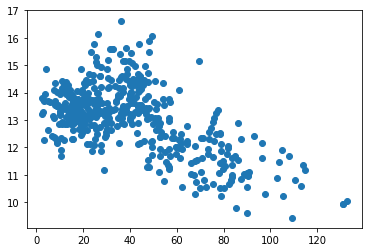

In [5]:
miles, hours, feet = [rides[attr] for attr in ('miles', 'hours', 'feet')]

plt.scatter(feet/miles, miles/hours);

# Making it Prettier

As expected, there is a lot of variance, but overall speeds get slower as the grade gets steeper. I'll attempt to summarize the data by plotting three best-fit curves to the data: a straight line (degree 1 polynomial), a quadratic (degree 2) and a cubic (degree 3). I'll also make the plot prettier and bigger:

In [6]:
def show(X, Y, xlabel='Grade (feet/mile)', ylabel='Speed (mph)', degrees=(1, 2, 3)): 
    """Plot X versus Y and a best fit curve to it, with some bells and whistles."""
    plt.rcParams["figure.figsize"] = (9, 7)
    grid(); plt.ylabel(ylabel); plt.xlabel(xlabel)
    plt.scatter(X, Y, c='k', marker='+')
    X1 = np.linspace(min(X), max(X), 100)
    for degree in degrees:
        F = poly_fit(X, Y, degree)
        plt.plot(X1, [F(x) for x in X1], '-', lw=2)
    plt.title(f'{len(X)} data points')

def grid(): plt.minorticks_on(); plt.grid(which='both', ls=':', alpha=0.7)
    
def poly_fit(X, Y, degree) -> callable:
    """The polynomial function that best fits the X,Y vectors."""
    coeffs = np.polyfit(X, Y, degree)[::-1]
    return lambda x: sum(c * x ** i for i, c in enumerate(coeffs))         

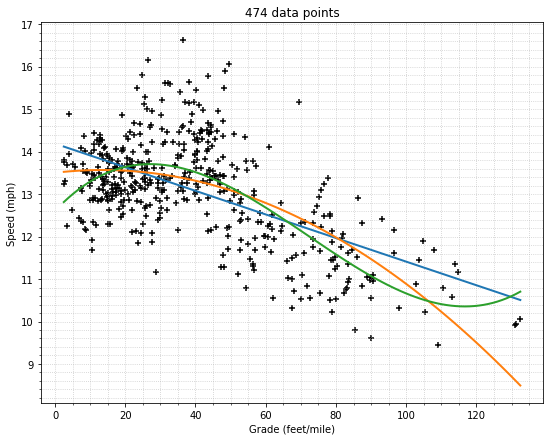

In [7]:
show(X=feet/miles, Y=miles/hours)

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort (and maybe the wind) than on the grade of the road. But when the grade is steeper than 50 ft/mile, the speed falls off quickly: down to 12mph at 80 ft/mile;  11 mph at 100 ft/mile; and around 10 mph at 120 ft/mile. Note that 120 ft/mile is only 2.3% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flat, then that's 6.9% average grade on the up part.

# Estimating Time of a Ride

This data can help me predict how long will it take to ride a route with a given distance and elevation. For example, to get to  Pescadero from La Honda, I could take the flatter [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (15.7 miles, 344 ft climb), or the shorter [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (13.5 miles, 735 ft climb); which is faster?

In [8]:
def estimate(dist, climb, F=poly_fit(feet/miles, miles/hours, 2)) -> float:
    """Given a distance in miles and total climb in feet, estimate time in minutes."""
    return 60 * dist / F(climb / dist)

In [9]:
f'Coast: {estimate(15.7, 344):.0f} min, Creek: {estimate(13.5, 735):.0f} min.'

'Coast: 70 min, Creek: 62 min.'

This predicts the shorter creek route would be 10% faster. Good to know, but other factors (like the scenery) are probably more important in making the choice.

# Segments

The data I have so far helps me estimate the duration for a long ride over varying up-and-down terrain. But what if I just want to know how long it will take to climb the next hill? To answer that I'll go back to Strava and retrieve data from individual **segments**, some only a fraction of a mile long, some several miles long, but most with a relatively constant grade. I picked some representative climbing segments ([`bikesegments.csv`](bikesegments.csv)) with the segment length in miles and climb in feet, along with several of my times on the segment. (Strava shows my times for up to 10 rides on each segment; I picked the fastest, middle, and slowest of the rides shown.) 

In [10]:
def parse_segments(lines):
    """Parse a string of segments into Rides. Each line contains:
    'segment_title, miles, feet_climb, time(s), ...'."""
    for segment in lines:
        title, mi, ft, *times = segment.split(',')
        for time in times:
            yield title, float(mi), parse_int(ft), parse_hours(time)
            
segments = pd.DataFrame(parse_segments(open('bikesegments.csv')),
                        columns=('title', 'miles', 'feet', 'hours'))

In [11]:
segments

,title,miles,feet,hours
0,Alma Mt. Charlie,3.12,875,0.530
1,Alpine Westridge,0.76,99,0.057
2,Alpine Westridge,0.76,99,0.058
3,Alpine Westridge,0.76,99,0.062
4,Alpine last kicker,0.39,114,0.053
...,...,...,...,...
132,Westridge Hill 2,0.51,166,0.086
133,Westridge Hill 2,0.51,166,0.089
134,Woodside Climb,1.71,295,0.135
135,Woodside Climb,1.71,295,0.150


For this plot I will list grade in percent rather than climbing feet per mile (a 1% grade is 52.8 feet  per mile):

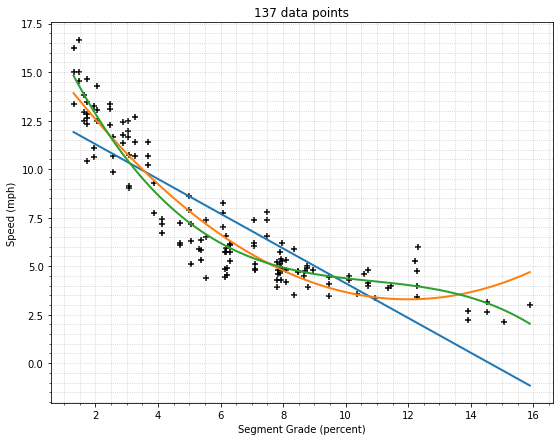

In [12]:
miles2, hours2, feet2 = (segments[attr] for attr in ('miles', 'hours', 'feet'))

pct2 = feet2 / miles2 * 100 / 5280

show(pct2, miles2 / hours2, xlabel='Segment Grade (percent)')  

So I can cruise at 15 to 17 mph on a 1% grade, but only about 8 mph at 5% grade, and around 5 mph on 8% grades.

# VAM

The average number of vertical feet (or meters) climbed per hour (regardless of horizontal distance travelled) is known as [VAM](https://en.wikipedia.org/wiki/VAM_%28bicycling%29), which stands for *velocità ascensionale media* (for native Campagnolo speakers) or *mean ascent velocity* (for SRAM) or 平均上昇率 (for Shimano). The theory is that for medium-steepish climbs, most of your power is going into lifting against gravity, so your VAM should be about constant no matter what the grade in that range. (For flatish rides power is spent on wind and rolling resistance, and for super-steep rides power goes largely to cursing *sotto voce*, as they say in Italian.) Here's a plot of my VAM versus grade (in percent):

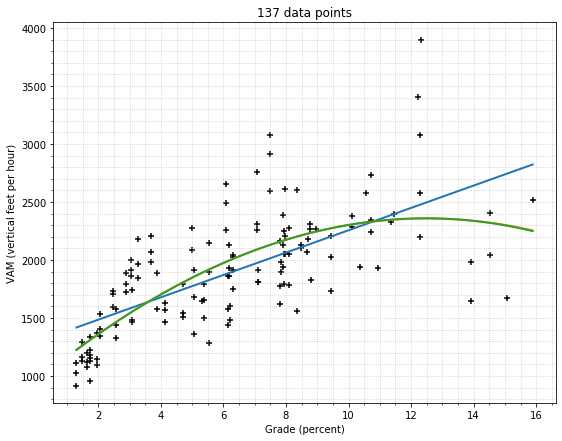

In [13]:
show(pct2, feet2 / hours2, xlabel='Grade (percent)', 
     ylabel='VAM (vertical feet per hour)')

I don't see the flattening effect; I see a wide spread of VAM numbers; at about 8% I range from 1500 to 3000 VAM. Champions can do  6000. 




# Hill-Index

Inspired by the [h-index](https://en.wikipedia.org/wiki/H-index) for scientific publications, I invented a new metric, the hill-index:

> *Your **hill-index** is the maximum number**&nbsp;h** for which you can regularly climb an**&nbsp;h** percent grade at **&nbsp;h** miles per hour.*

I think **my hill-index is 6**. (I know that [Old La Honda](https://graphics.stanford.edu/~lucasp/grade/oldlahonda.html) is a 7% grade, and I only [achieved 7.0 mph](https://www.strava.com/segments/9343401?filter=my_results&gender=all) on it once out of many tries). But let's draw a plot to confirm:

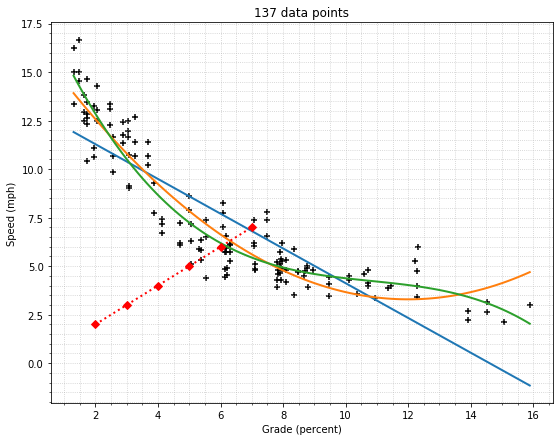

In [14]:
show(pct2, miles2 / hours2, xlabel='Grade (percent)')  
plt.plot(range(2, 8), range(2, 8), 'rD:', lw=2);

The  red dotted line is where grade = speed. All three  best-fit curves are above the diamond at 6% and below the diamond for 7%, so my guess is confirmed: my hill-index is 6.



# Eddington Number

Speaking of h-numbers, the  physicist [Sir Arthur Eddington](https://en.wikipedia.org/wiki/Arthur_Eddington) (1882-1944), a contemporary of Einstein, was a pre-Strava bicyclist who favored this metric:

> *Your [Eddington Number](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the largest integer **e** such that you have bicycled at least**&nbsp;e** miles on at least**&nbsp;e** days.*

Let's calculate mine:

In [15]:
def E_number(distances) -> int:
    """Eddington number: The maximum integer e such that you have bicycled 
    a distance of at least e on at least e days."""
    distances = sorted(distances, reverse=True)
    return max(e for e, d in enumerate(distances, 1) if d >= e)

In [16]:
E_number(miles)

61

My **Eddington Number is 61**: I've done at least 61 miles on at least 61 days. This is a bit above [the mean for Strava users](https://swinny.net/Cycling/-4687-Calculate-your-Eddington-Number), but not as good as Eddington himself: he had a number of **84** when he died at age 62, and his roads, bicycles, and navigation aids were not nearly as nice as mine, so bravo for him.

Here are some properties of Eddington numbers:
- Your Eddington number is monotonic: it can never decrease over time. (This is also true of the academic h-index, but not my hill-index.)
- To improve from an Eddington number of *n* to *n* + 1 can take as few as 1 ride, or as many as *n* + 1 rides. (Suppose I have done 49 rides, each of exactly 50 miles.  Then my Eddington number is 49, and with one more 50-mile ride, my number becomes 50, but then I would need 51 rides of 51 miles each to achieve an Eddington number of 51.)
- You could also compute a metric Eddington number, using kilometers rather than miles.
- Your metric Eddington number will always be greater than or equal to your imperial Eddington number.
- Your metric Eddington number will never be more than 1.609344 times your  imperial Eddington number.
- Of two riders, it is possible that one has a higher metric number and the other a higher imperial number.

The following chart tells me how many rides I have to go&mdash;what I call the **Eddington Gap**&mdash;to reach various Eddington numbers:

In [17]:
def E_gaps(distances, targets, unit='miles'):
    """Print the number of days doing various target distances, and the Eddington gap."""
    rows = [(target, sum(distances > target), target - sum(distances > target))
            for target in targets]
    return showdf(pd.DataFrame(rows, columns=[unit, 'days', 'gap']))

def showdf(df: pd.DataFrame) -> HTML:
    """Show a DataFrame as HTML, but without the index number."""
    return HTML(df.to_html(index=False))

E_gaps(miles, range(61, 76))

miles,days,gap
61,62,-1
62,60,2
63,58,5
64,56,8
65,53,12
66,50,16
67,43,24
68,40,28
69,30,39
70,29,41


An easy way to get bigger Eddington numbers is to use kilometers rather than miles:

In [18]:
kms = 1.609344 * miles

E_number(kms)

85

In [19]:
E_gaps(kms, range(85, 101))

miles,days,gap
85,86,-1
86,85,1
87,83,4
88,82,6
89,81,8
90,80,10
91,78,13
92,77,15
93,74,19
94,72,22


My **metric Eddington Number is 85**.

Here is my Eddington number progress over the years, in miles and kms, from when I first started tracking rides:

In [20]:
def year(ride) -> int: return int(ride.date[-4:])

def E_progress(years, rides=rides):
    """Print a table of Eddington numbers by year"""
    def row(y):
        miles = np.array([r.miles for r in rides.itertuples() if year(r) <= y])
        kms   = 1.609344 * miles
        E_ml, E_km = E_number(miles), E_number(kms)
        return [y, E_ml, E_km, round(E_km/E_ml, 2)]
    return showdf(pd.DataFrame(map(row, years), columns=['year', 'E_ml', 'E_km', 'ratio']))

In [21]:
E_progress(range(2014, 2021))

year,E_ml,E_km,ratio
2014,34,45,1.32
2015,41,60,1.46
2016,46,65,1.41
2017,50,72,1.44
2018,53,75,1.42
2019,54,78,1.44
2020,61,85,1.39


*Note:* the definition of Eddington Number seems to be mathematically precise, but there is one big ambiguity: what exactly does the word ***day*** mean? The New Oxford dictionary mentions (a) "a period of 24 hours"; (b) "a unit of time, reckoned from one midnight to the next"; and (c) "the part of a day when it is light".  I originally assumed ***day*** meant "one midnight to the next," but I wanted to make an exception for bikepacking trips where I rode to a camping site in the afternoon, spent the night there, and rode back home the next morning; what bikepackers call a [sub-24-hour overnight (S24O)](https://oneofsevenproject.com/s24o-bikepacking-guide/). I thought that should count as a valid Eddington trip as long as it was completed in 24 hours. And then COVID struck, the camping sites closed, and in response I further relaxed the definition to allow an S24O ride where I sleep in my own home, as long as all the riding is within "a period of 24 hours." I realize Eddington had a lot more hardships than we have (the 1918 pandemic, World War I, and World War II), but I hope he would approve of this accomodation on my part.

# Wandering

The website [`wandrer.earth`](https://wandrer.earth) tracks the number of miles of distinct roads you have travelled on (taken from your Strava data). I realize I often repeat the same routes, so this gives me a chance to try something new. Below I plot the percentage of roads I've travelled in various places, across different months.

In [22]:
dates =                       '20/7',  '20/8', '20/9', '20/10' # Year/Month
data  = {
 'Earth': [                 
     ('California',  361_433,  0.712,  0.811,  0.846,  0.867),
     ('USA',       6_270_601,  0.048,  0.052,  0.055,  0.05589),
     ('Earth',    37_010_550,  0.0081, 0.0089, 0.0091, 0.00936)
 ],
    
 'Counties': [        # Miles  20/7, 20/8,  20/9, 20/10
     ('Alameda',         5704,  3.3,  3.3,  3.3,  3.9),
     ('Marin',           2322,  6.7,  6.7,  6.7,  6.7),
     ('Napa',            1524,  5.1,  5.1,  5.1,  5.1),
     ('Sonoma',          4556,  5.1,  5.1,  5.1,  5.1),
     ('San Francisco',   1183,  4.5,  4.5,  4.5,  4.5),
     ('San Mateo',       3248, 20.1, 21.2, 22.9, 23.4),
     ('Santa Clara',     7412, 12.7, 13.6, 15.4, 15.6),
     ('Santa Cruz',      2767,  2.3,  2.3,  2.3,  2.3),
     ('Grant (OR)',      8049,  2.6,  2.6,  2.6,  2.6),
     ('Baker (OR)',      5170,  2.4,  2.4,  2.4,  2.4),
     ('New York (NY)',   6689,  0.4,  0.4,  0.4,  0.4),
 ],

 'San Mateo County': [
     ('Belmont',           98, 15.5, 17.3, 18.6, 18.6),
     ('East Palo Alto',    46, 74.4, 91.2, 91.9, 91.9),
     ('Emerald Lake Hills', 2,  0.0, 94.0, 94.3, 94.3),
     ('Foster City',      150,  9.1,  9.1,  9.1,  9.1),
     ('Kensington Square',  1, 86.9, 99.4, 100., 100.),
     ('Menlo Park',       139, 67.7, 76.8, 87.7, 90.7),
     ('North Fair Oaks',   27, 48.1, 90.4, 93.1, 93.8),
     ('Redwood City',     241, 34.0, 39.1, 46.0, 51.6),
     ('San Carlos',        99, 22.2, 26.0, 32.9, 32.9),
     ('San Mateo',        412, 11.1, 11.1, 11.1, 11.1),
     ('Woodside',          78, 51.9, 51.9, 52.3, 52.3),
 ],

 'Santa Clara County': [
     ('Cupertino',        172, 22.1, 23.9, 26.2, 26.2),
     ('Campbell',         120,  8.9, 10.1, 12.4, 12.4),
     ('Los Altos',        138, 40.2, 43.7, 72.4, 77.2),
     ('Los Altos Hills',   91, 48.4, 48.4, 49.0, 55.1),
     ('Los Gatos',        152,  7.5,  8.6,  8.8,  8.8),
     ('Monte Sereno',      21, 20.4, 20.4, 20.5, 20.5),
     ('Mountain View',    207, 53.0, 59.9, 63.0, 63.6),
     ('Palo Alto',        293, 63.0, 73.6, 85.4, 85.7),
     ('San Jose',        2545, 1.30, 1.36,  5.3,  5.3),
     ('Santa Clara',      348,  6.4,  6.4,  9.6,  9.6),
     ('Saratoga',         180, 14.5, 15.7, 17.4, 17.4),
     ('Sunnyvale',        361, 19.4, 19.9, 22.2, 22.2),
 ]}

In [23]:
def wandrer(title, data=data, dates=dates):
    """Plot Wandrer.earth data."""
    entries = sorted(data[title], key=lambda e: -e[-1])
    months  = [num_months(d) for d in dates]
    markers = 'osdhDHPX*><v^p|67'
    fig = plt.figure()
    ax = plt.subplot(111)
    for (place, miles, *pcts), m in zip(entries, markers):
        ax.plot(months, pcts, ':', marker=m, lw=1.5,
                 label=f'{place}: {int(round(miles * pcts[-1] / 100)):,d}/{miles:,d} mi, {pcts[-1]}%')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)
    plt.xticks(months, dates); grid()
    plt.ylabel('Percent of Area Ridden'); plt.xlabel('Year/Month')
    plt.title(title); plt.tight_layout(); plt.show()
    
def num_months(date) -> int:
    """num_months("20/9") = 20 * 12 + 9 = 249"""
    year, month = date.split('/')
    return int(year) * 12 + int(month)

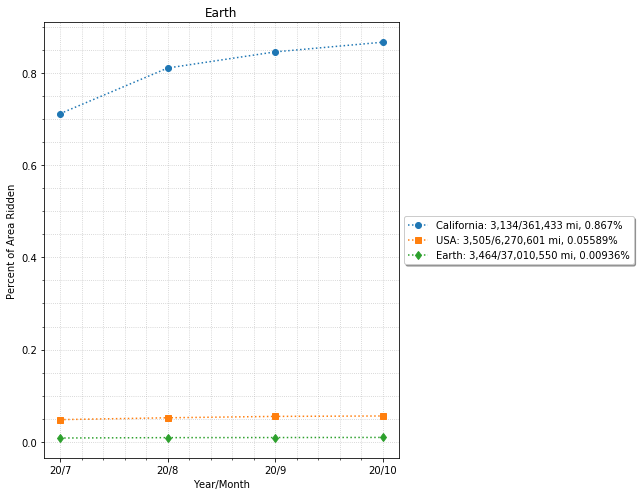

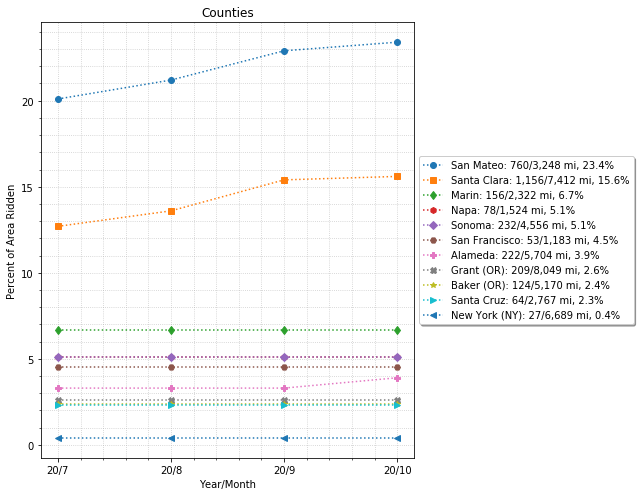

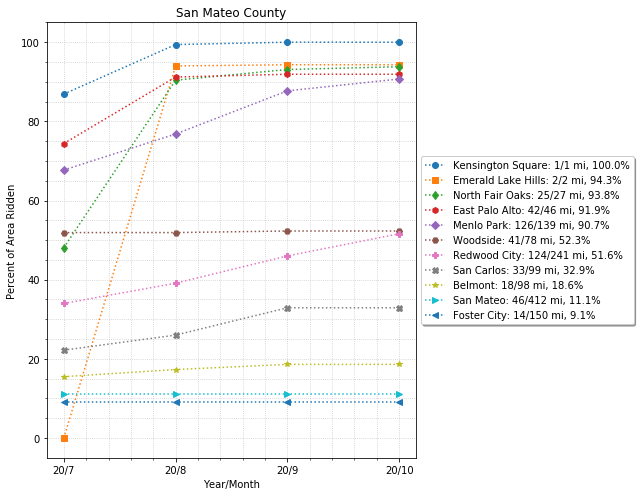

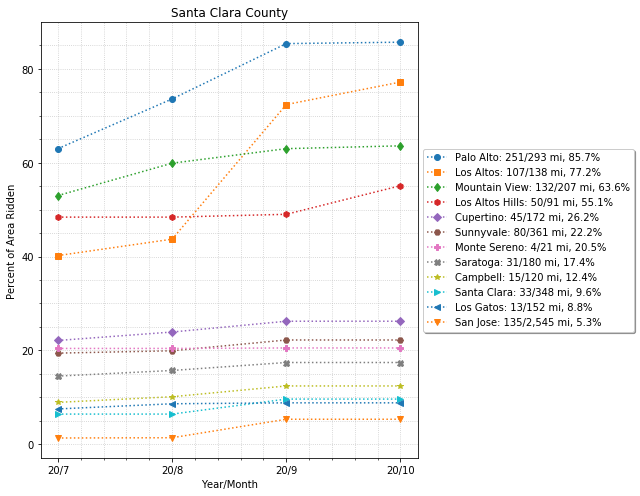

In [24]:
for title in data:
    wandrer(title)